In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time
import os
import torch.nn.functional as F
from tqdm import tqdm

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights


print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
1


In [9]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 25
num_workers = 2
batch_size = 100
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 20
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

In [3]:
# Load CIFAR-100 dataset
trainloader, testloader  = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
###################### Testing 1 ######################
# Create instances of your models
teacher = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
teacher.eval()  # Set teacher model to evaluation mode
student = torchvision.models.resnet18(weights=None).cuda()

In [3]:
###################### Testing 2 ######################
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        
        self.layer1 = nn.Linear(3072, 1200)
        self.layer2 = nn.Linear(1200, 1200)
        self.layer3 = nn.Linear(1200, 100)
        
        self.dropout_20 = nn.Dropout(0.2)
        self.dropout_50 = nn.Dropout(0.5)

    def forward(self, x):
        # Check input shape and resize if necessary
        if x.shape[-3:] != (3, 32, 32):
            x = x[:, :3, :32, :32]
        
        x = x.contiguous().view(x.size(0), -1)  # Flatten the input
        x = self.dropout_20(x)
        x = F.relu(self.layer1(x))
        x = self.dropout_50(x)
        x = F.relu(self.layer2(x))
        x = self.dropout_50(x)
        return self.layer3(x)

class Student(nn.Module):
    def __init__(self, use_dropout=False):
        super(Student, self).__init__()
        self.use_dropout = use_dropout
        
        self.layer1 = nn.Linear(3072, 800)
        self.layer2 = nn.Linear(800, 800)
        self.layer3 = nn.Linear(800, 100)
        
        self.dropout_20 = nn.Dropout(0.2)
        self.dropout_50 = nn.Dropout(0.5)

    def forward(self, x):
        # Check input shape and resize if necessary
        if x.shape[-3:] != (3, 32, 32):
            x = x[:, :3, :32, :32]
            
        x = x.contiguous().view(x.size(0), -1)  # Flatten the input
        if self.use_dropout:
            x = self.dropout_20(x)
        x = F.relu(self.layer1(x))
        if self.use_dropout:
            x = self.dropout_50(x)
        x = F.relu(self.layer2(x))
        if self.use_dropout:
            x = self.dropout_50(x)
        return self.layer3(x)


# Create instances of your models
teacher = Teacher()
teacher.eval()  # Set teacher model to evaluation mode
student = Student()

In [8]:
# Optimizer and scheduler for the student model
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

In [6]:
# # https://github.com/yushundong/RELIANT/blob/main/src/CPF-master/distill_dgl.py

# def fair_metric(pred, labels, sens):
#     sens = sens.cpu()
#     labels = labels.cpu()
#     idx_s0 = sens == 0
#     idx_s1 = sens == 1
#     idx_s0_y1 = idx_s0 & (labels == 1)
#     idx_s1_y1 = idx_s1 & (labels == 1)

#     if idx_s0.sum().item() == 0 or idx_s1.sum().item() == 0 or idx_s0_y1.sum().item() == 0 or idx_s1_y1.sum().item() == 0:
#         return torch.tensor(0.0), torch.tensor(0.0)  # Return zeros

#     parity = torch.abs((pred[idx_s0].sum() / (idx_s0.sum().item() + 1e-8)) - (pred[idx_s1].sum() / (idx_s1.sum().item() + 1e-8)))
#     equality = torch.abs((pred[idx_s0_y1].sum() / (idx_s0_y1.sum().item() + 1e-8)) - (pred[idx_s1_y1].sum() / (idx_s1_y1.sum().item() + 1e-8)))

#     return parity.item(), equality.item()

# def approx_loss(logits, sens, idx):
#     logits, sens, idx = logits.cpu(), sens.cpu(), idx.cpu()
#     g1 = np.argwhere(sens.numpy() == 0.0).reshape(-1)
#     g2 = np.argwhere(sens.numpy() == 1.0).reshape(-1)
#     idx_set = set(idx.numpy())
#     g1 = np.array(list(set(g1) & idx_set))
#     g2 = np.array(list(set(g2) & idx_set))

#     if g1.shape[0] == 0 or g2.shape[0] == 0:
#         return torch.tensor(0.0)  # Return zero

#     loss = torch.square(approx_func(logits[g1]).sum(axis=0) / (g1.shape[0]) - approx_func(logits[g2]).sum(axis=0) / (g2.shape[0])).sum()
#     return loss

# def approx_loss_eo(logits, sens, labels, idx):
#     logits, sens, labels, idx = logits.cpu(), sens.cpu(), labels.cpu(), idx.cpu()
#     g1 = np.argwhere(sens.numpy() == 0).reshape(-1)
#     g2 = np.argwhere(sens.numpy() == 1).reshape(-1)
#     g = np.argwhere(labels.numpy() == 1).reshape(-1)
#     idx_set = set(idx.numpy())
#     g1 = np.array(list(set(g1) & set(g) & idx_set))
#     g2 = np.array(list(set(g2) & set(g) & idx_set))
    
#     if g1.shape[0] == 0 or g2.shape[0] == 0:
#         return torch.tensor(0.0)  # Return zero 

#     loss = torch.square(approx_func(logits[g1]).sum(axis=0) / (g1.shape[0] + 1e-8) - approx_func(logits[g2]).sum(axis=0) / (g2.shape[0] + 1e-8)).sum()
#     return loss

# def approx_func(s):
#     device = s.device  # Store the device information
#     dtype = s.dtype    # Store the data type information
#     s = s.detach().cpu().numpy()
#     x = 2 * s - 1
#     result = 1 / 2 + 1 / 2 * x - 1 / 8 / 2 * (5 * x * x * x - 3 * x) + 1 / 16 / 8 * (
#                 63 * x * x * x * x * x - 70 * x * x * x + 15 * x) - 5 / 128 / 16 * (
#                        429 * x * x * x * x * x * x * x - 693 * x * x * x * x * x + 315 * x * x * x - 35 * x) + 7 / 256 / 128 * (
#                        12155 * x * x * x * x * x * x * x * x * x - 25740 * x * x * x * x * x * x * x + 18018 * x * x * x * x * x - 4620 * x * x * x + 315 * x)
#     return torch.tensor(result, device=device, dtype=dtype)


In [11]:
# Knowledge Distillation loss function
def knowledge_distillation_loss(student_outputs, teacher_outputs, temperature):
    kd_loss = F.kl_div(
        F.log_softmax(student_outputs / temperature, dim=1),
        F.softmax(teacher_outputs / temperature, dim=1),
        reduction='batchmean'
    ) * (temperature * temperature)
    return kd_loss

# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Loss computation
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        
        # Step the learning rate scheduler
        scheduler.step()
        
    print("Finished Training Teacher")



# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            
            ce_loss = criterion(student_outputs, labels)
            kd_loss = knowledge_distillation_loss(student_outputs, teacher_outputs, temperature)
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        
        scheduler.step()
        
    print("Finished Training Student")


# Call the function to train the teacher model
train_teacher(teacher, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:45,  2.39it/s]

[1, 100] loss: 5.931


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:05,  2.37it/s]

[1, 200] loss: 3.661


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:23,  2.37it/s]

[1, 300] loss: 2.749


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:48<02:42,  2.35it/s]

[1, 400] loss: 2.180


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:30<02:00,  2.35it/s]

[1, 500] loss: 1.836


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:13<01:17,  2.33it/s]

[1, 600] loss: 1.623


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:27<01:04,  1.27it/s]

[1, 700] loss: 1.443


 13%|██████████████▏                                                                                                | 100/782 [01:20<09:05,  1.25it/s]

[2, 100] loss: 1.069


 26%|████████████████████████████▍                                                                                  | 200/782 [02:38<06:47,  1.43it/s]

[2, 200] loss: 1.016


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:49<05:45,  1.39it/s]

[2, 300] loss: 0.994


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [05:00<04:31,  1.41it/s]

[2, 400] loss: 0.957


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [06:11<03:23,  1.39it/s]

[2, 500] loss: 0.952


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [07:22<02:07,  1.42it/s]

[2, 600] loss: 0.911


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [08:33<00:58,  1.41it/s]

[2, 700] loss: 0.867


 13%|██████████████▏                                                                                                | 100/782 [01:11<08:06,  1.40it/s]

[3, 100] loss: 0.590


 26%|████████████████████████████▍                                                                                  | 200/782 [02:22<06:53,  1.41it/s]

[3, 200] loss: 0.580


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:33<05:43,  1.40it/s]

[3, 300] loss: 0.584


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [04:44<04:34,  1.39it/s]

[3, 400] loss: 0.570


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [05:56<03:19,  1.41it/s]

[3, 500] loss: 0.583


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [07:06<02:09,  1.41it/s]

[3, 600] loss: 0.560


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [08:18<00:59,  1.38it/s]

[3, 700] loss: 0.585


 13%|██████████████▏                                                                                                | 100/782 [01:11<08:03,  1.41it/s]

[4, 100] loss: 0.352


 26%|████████████████████████████▍                                                                                  | 200/782 [02:22<06:54,  1.40it/s]

[4, 200] loss: 0.346


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:32<05:27,  1.47it/s]

[4, 300] loss: 0.344


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [04:40<04:19,  1.47it/s]

[4, 400] loss: 0.342


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [05:48<03:14,  1.45it/s]

[4, 500] loss: 0.351


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [06:56<02:02,  1.48it/s]

[4, 600] loss: 0.356


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [08:01<00:53,  1.55it/s]

[4, 700] loss: 0.365


 13%|██████████████▏                                                                                                | 100/782 [01:17<08:46,  1.29it/s]

[5, 100] loss: 0.210


 26%|████████████████████████████▍                                                                                  | 200/782 [02:35<07:26,  1.30it/s]

[5, 200] loss: 0.204


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:53<04:04,  1.97it/s]

[5, 300] loss: 0.198


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [04:36<02:45,  2.31it/s]

[5, 400] loss: 0.196


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [05:19<02:02,  2.30it/s]

[5, 500] loss: 0.195


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [06:03<01:19,  2.30it/s]

[5, 600] loss: 0.204


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [06:46<00:35,  2.30it/s]

[5, 700] loss: 0.211


 13%|██████████████▏                                                                                                | 100/782 [00:43<04:56,  2.30it/s]

[6, 100] loss: 0.109


 26%|████████████████████████████▍                                                                                  | 200/782 [01:26<04:15,  2.28it/s]

[6, 200] loss: 0.114


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:10<03:29,  2.30it/s]

[6, 300] loss: 0.111


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:53<02:46,  2.30it/s]

[6, 400] loss: 0.113


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:37<02:02,  2.30it/s]

[6, 500] loss: 0.105


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:20<01:18,  2.31it/s]

[6, 600] loss: 0.115


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:03<00:34,  2.36it/s]

[6, 700] loss: 0.110


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:48,  2.36it/s]

[7, 100] loss: 0.065


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:06,  2.36it/s]

[7, 200] loss: 0.063


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:06<03:21,  2.39it/s]

[7, 300] loss: 0.059


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:48<02:39,  2.40it/s]

[7, 400] loss: 0.062


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:30<01:58,  2.39it/s]

[7, 500] loss: 0.063


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:12<01:16,  2.38it/s]

[7, 600] loss: 0.067


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:54<00:34,  2.36it/s]

[7, 700] loss: 0.061


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[8, 100] loss: 0.039


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[8, 200] loss: 0.037


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[8, 300] loss: 0.036


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:41,  2.36it/s]

[8, 400] loss: 0.034


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:57,  2.40it/s]

[8, 500] loss: 0.037


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:15,  2.40it/s]

[8, 600] loss: 0.036


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:55<00:34,  2.40it/s]

[8, 700] loss: 0.038


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:44,  2.39it/s]

[9, 100] loss: 0.023


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:02,  2.40it/s]

[9, 200] loss: 0.024


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:22,  2.38it/s]

[9, 300] loss: 0.024


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:47<02:40,  2.37it/s]

[9, 400] loss: 0.027


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:29<02:00,  2.34it/s]

[9, 500] loss: 0.025


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:12<01:17,  2.35it/s]

[9, 600] loss: 0.025


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:55<00:35,  2.30it/s]

[9, 700] loss: 0.025


 13%|██████████████▏                                                                                                | 100/782 [00:43<04:56,  2.30it/s]

[10, 100] loss: 0.019


 26%|████████████████████████████▍                                                                                  | 200/782 [01:27<04:13,  2.29it/s]

[10, 200] loss: 0.018


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:10<03:29,  2.30it/s]

[10, 300] loss: 0.017


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:54<02:46,  2.30it/s]

[10, 400] loss: 0.019


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:37<02:02,  2.30it/s]

[10, 500] loss: 0.019


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:21<01:19,  2.30it/s]

[10, 600] loss: 0.020


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:04<00:35,  2.30it/s]

[10, 700] loss: 0.020


 13%|██████████████▏                                                                                                | 100/782 [00:43<04:56,  2.30it/s]

[11, 100] loss: 0.016


 26%|████████████████████████████▍                                                                                  | 200/782 [01:26<04:13,  2.30it/s]

[11, 200] loss: 0.014


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:10<03:30,  2.30it/s]

[11, 300] loss: 0.015


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:54<02:46,  2.30it/s]

[11, 400] loss: 0.015


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:37<02:02,  2.31it/s]

[11, 500] loss: 0.016


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:20<01:19,  2.30it/s]

[11, 600] loss: 0.015


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:04<00:35,  2.30it/s]

[11, 700] loss: 0.014


 13%|██████████████▏                                                                                                | 100/782 [00:43<04:56,  2.30it/s]

[12, 100] loss: 0.011


 26%|████████████████████████████▍                                                                                  | 200/782 [01:26<04:12,  2.30it/s]

[12, 200] loss: 0.012


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:10<03:29,  2.30it/s]

[12, 300] loss: 0.011


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:53<02:46,  2.30it/s]

[12, 400] loss: 0.012


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:37<02:02,  2.30it/s]

[12, 500] loss: 0.010


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:20<01:17,  2.35it/s]

[12, 600] loss: 0.011


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:02<00:34,  2.37it/s]

[12, 700] loss: 0.012


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:48,  2.37it/s]

[13, 100] loss: 0.009


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:07,  2.35it/s]

[13, 200] loss: 0.008


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:06<03:24,  2.36it/s]

[13, 300] loss: 0.009


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:49<02:41,  2.36it/s]

[13, 400] loss: 0.010


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:31<01:59,  2.36it/s]

[13, 500] loss: 0.011


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:17,  2.35it/s]

[13, 600] loss: 0.009


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:56<00:34,  2.35it/s]

[13, 700] loss: 0.011


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:52,  2.33it/s]

[14, 100] loss: 0.012


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:10,  2.32it/s]

[14, 200] loss: 0.009


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:09<03:28,  2.31it/s]

[14, 300] loss: 0.009


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:52<02:45,  2.30it/s]

[14, 400] loss: 0.009


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:35<02:02,  2.29it/s]

[14, 500] loss: 0.010


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:19<01:19,  2.30it/s]

[14, 600] loss: 0.008


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:02<00:34,  2.35it/s]

[14, 700] loss: 0.009


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:56,  2.30it/s]

[15, 100] loss: 0.007


 26%|████████████████████████████▍                                                                                  | 200/782 [01:26<04:16,  2.27it/s]

[15, 200] loss: 0.007


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:09<03:27,  2.33it/s]

[15, 300] loss: 0.007


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:52<02:43,  2.34it/s]

[15, 400] loss: 0.007


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:35<02:00,  2.33it/s]

[15, 500] loss: 0.007


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:18<01:18,  2.33it/s]

[15, 600] loss: 0.008


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:01<00:35,  2.33it/s]

[15, 700] loss: 0.008


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[16, 100] loss: 0.008


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:09,  2.33it/s]

[16, 200] loss: 0.007


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:08<03:26,  2.33it/s]

[16, 300] loss: 0.006


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:51<02:41,  2.36it/s]

[16, 400] loss: 0.006


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<01:57,  2.40it/s]

[16, 500] loss: 0.007


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:15,  2.40it/s]

[16, 600] loss: 0.006


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:56<00:34,  2.40it/s]

[16, 700] loss: 0.006


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:44,  2.40it/s]

[17, 100] loss: 0.010


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:03,  2.39it/s]

[17, 200] loss: 0.008


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:22,  2.38it/s]

[17, 300] loss: 0.007


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:47<02:41,  2.36it/s]

[17, 400] loss: 0.007


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:29<01:59,  2.35it/s]

[17, 500] loss: 0.007


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:12<01:17,  2.35it/s]

[17, 600] loss: 0.007


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:55<00:35,  2.34it/s]

[17, 700] loss: 0.006


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:57,  2.30it/s]

[18, 100] loss: 0.006


 26%|████████████████████████████▍                                                                                  | 200/782 [01:26<04:13,  2.30it/s]

[18, 200] loss: 0.006


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:10<03:30,  2.29it/s]

[18, 300] loss: 0.006


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:53<02:45,  2.31it/s]

[18, 400] loss: 0.005


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:36<02:00,  2.35it/s]

[18, 500] loss: 0.006


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:19<01:18,  2.31it/s]

[18, 600] loss: 0.006


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:02<00:35,  2.30it/s]

[18, 700] loss: 0.006


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[19, 100] loss: 0.007


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[19, 200] loss: 0.005


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:08<03:26,  2.34it/s]

[19, 300] loss: 0.006


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:51<02:43,  2.33it/s]

[19, 400] loss: 0.005


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:34<02:01,  2.32it/s]

[19, 500] loss: 0.005


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:17<01:18,  2.33it/s]

[19, 600] loss: 0.006


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:59<00:35,  2.33it/s]

[19, 700] loss: 0.005


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:43,  2.41it/s]

[20, 100] loss: 0.005


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:02,  2.40it/s]

[20, 200] loss: 0.005


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:20,  2.40it/s]

[20, 300] loss: 0.006


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:39,  2.40it/s]

[20, 400] loss: 0.005


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:57,  2.40it/s]

[20, 500] loss: 0.005


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:10<01:16,  2.39it/s]

[20, 600] loss: 0.005


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:52<00:34,  2.38it/s]

[20, 700] loss: 0.005


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.36it/s]

[21, 100] loss: 0.005


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:08,  2.34it/s]

[21, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[21, 300] loss: 0.005


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:43,  2.34it/s]

[21, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.34it/s]

[21, 500] loss: 0.004


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.34it/s]

[21, 600] loss: 0.004


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:35,  2.34it/s]

[21, 700] loss: 0.004


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:52,  2.33it/s]

[22, 100] loss: 0.004


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:06,  2.36it/s]

[22, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:20,  2.40it/s]

[22, 300] loss: 0.004


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:49<02:39,  2.39it/s]

[22, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:30<01:57,  2.40it/s]

[22, 500] loss: 0.004


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:12<01:15,  2.40it/s]

[22, 600] loss: 0.004


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:54<00:34,  2.39it/s]

[22, 700] loss: 0.004


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:46,  2.38it/s]

[23, 100] loss: 0.004


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:06,  2.36it/s]

[23, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:06<03:24,  2.35it/s]

[23, 300] loss: 0.004


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:48<02:42,  2.35it/s]

[23, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:31<02:00,  2.35it/s]

[23, 500] loss: 0.004


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:13<01:16,  2.39it/s]

[23, 600] loss: 0.004


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:55<00:34,  2.40it/s]

[23, 700] loss: 0.004


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:44,  2.40it/s]

[24, 100] loss: 0.003


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:02,  2.40it/s]

[24, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:20,  2.40it/s]

[24, 300] loss: 0.004


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:39,  2.39it/s]

[24, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:58,  2.37it/s]

[24, 500] loss: 0.004


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:11<01:17,  2.36it/s]

[24, 600] loss: 0.004


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:53<00:34,  2.34it/s]

[24, 700] loss: 0.004


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[25, 100] loss: 0.004


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[25, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:08<03:26,  2.34it/s]

[25, 300] loss: 0.004


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:43,  2.34it/s]

[25, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<02:00,  2.33it/s]

[25, 500] loss: 0.004


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:16<01:17,  2.34it/s]

[25, 600] loss: 0.004


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:35,  2.33it/s]

[25, 700] loss: 0.004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:33<00:00,  2.34it/s]


Finished Training Teacher


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[1, 100] loss: 12.870


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:53,  2.49it/s]

[1, 200] loss: 10.020


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:12,  2.50it/s]

[1, 300] loss: 9.225


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:40<02:33,  2.50it/s]

[1, 400] loss: 9.000


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:20<01:52,  2.50it/s]

[1, 500] loss: 8.757


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:00<01:12,  2.50it/s]

[1, 600] loss: 8.632


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:40<00:32,  2.50it/s]

[1, 700] loss: 8.575


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.51it/s]

[2, 100] loss: 8.355


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:52,  2.50it/s]

[2, 200] loss: 8.249


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:12,  2.50it/s]

[2, 300] loss: 8.201


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:40<02:32,  2.50it/s]

[2, 400] loss: 8.186


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:20<01:53,  2.49it/s]

[2, 500] loss: 8.063


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:00<01:12,  2.50it/s]

[2, 600] loss: 8.055


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:40<00:32,  2.49it/s]

[2, 700] loss: 8.051


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.50it/s]

[3, 100] loss: 7.892


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:52,  2.50it/s]

[3, 200] loss: 7.893


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.50it/s]

[3, 300] loss: 7.740


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.51it/s]

[3, 400] loss: 7.662


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:53,  2.49it/s]

[3, 500] loss: 7.682


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:00<01:13,  2.49it/s]

[3, 600] loss: 7.651


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:40<00:33,  2.43it/s]

[3, 700] loss: 7.741


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:32,  2.50it/s]

[4, 100] loss: 7.524


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:52,  2.50it/s]

[4, 200] loss: 7.523


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:12,  2.50it/s]

[4, 300] loss: 7.409


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:40<02:33,  2.49it/s]

[4, 400] loss: 7.434


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:50,  2.54it/s]

[4, 500] loss: 7.347


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:10,  2.56it/s]

[4, 600] loss: 7.275


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.56it/s]

[4, 700] loss: 7.245


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:26,  2.56it/s]

[5, 100] loss: 7.159


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:48,  2.55it/s]

[5, 200] loss: 7.156


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:09,  2.55it/s]

[5, 300] loss: 7.001


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:28,  2.56it/s]

[5, 400] loss: 7.092


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:50,  2.55it/s]

[5, 500] loss: 7.114


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:54<01:11,  2.56it/s]

[5, 600] loss: 7.008


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:33<00:32,  2.55it/s]

[5, 700] loss: 6.961


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:27,  2.55it/s]

[6, 100] loss: 6.884


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:48,  2.55it/s]

[6, 200] loss: 6.716


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:10,  2.53it/s]

[6, 300] loss: 6.685


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:31,  2.53it/s]

[6, 400] loss: 6.727


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:16<01:52,  2.52it/s]

[6, 500] loss: 6.680


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:56<01:12,  2.51it/s]

[6, 600] loss: 6.728


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.50it/s]

[6, 700] loss: 6.641


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:33,  2.49it/s]

[7, 100] loss: 6.542


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:53,  2.49it/s]

[7, 200] loss: 6.413


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:13,  2.49it/s]

[7, 300] loss: 6.403


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:40<02:33,  2.50it/s]

[7, 400] loss: 6.450


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:20<01:52,  2.50it/s]

[7, 500] loss: 6.398


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:00<01:12,  2.49it/s]

[7, 600] loss: 6.346


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:40<00:32,  2.50it/s]

[7, 700] loss: 6.232


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:27,  2.55it/s]

[8, 100] loss: 6.178


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:48,  2.55it/s]

[8, 200] loss: 6.128


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:08,  2.56it/s]

[8, 300] loss: 6.113


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:29,  2.55it/s]

[8, 400] loss: 6.122


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:50,  2.56it/s]

[8, 500] loss: 6.195


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:54<01:11,  2.56it/s]

[8, 600] loss: 5.979


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:34<00:32,  2.56it/s]

[8, 700] loss: 5.919


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:27,  2.55it/s]

[9, 100] loss: 5.857


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:47,  2.56it/s]

[9, 200] loss: 5.843


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:08,  2.56it/s]

[9, 300] loss: 5.869


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:29,  2.55it/s]

[9, 400] loss: 5.880


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:50,  2.55it/s]

[9, 500] loss: 5.704


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:54<01:11,  2.56it/s]

[9, 600] loss: 5.845


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:34<00:32,  2.55it/s]

[9, 700] loss: 5.748


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:27,  2.55it/s]

[10, 100] loss: 5.683


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:48,  2.54it/s]

[10, 200] loss: 5.617


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:13,  2.49it/s]

[10, 300] loss: 5.489


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:33,  2.48it/s]

[10, 400] loss: 5.464


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:53,  2.48it/s]

[10, 500] loss: 5.505


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:14,  2.44it/s]

[10, 600] loss: 5.435


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:39<00:33,  2.46it/s]

[10, 700] loss: 5.566


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:37,  2.46it/s]

[11, 100] loss: 5.351


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:57,  2.46it/s]

[11, 200] loss: 5.330


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:02<03:15,  2.46it/s]

[11, 300] loss: 5.297


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:35,  2.46it/s]

[11, 400] loss: 5.315


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:55,  2.45it/s]

[11, 500] loss: 5.237


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:13,  2.46it/s]

[11, 600] loss: 5.219


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.46it/s]

[11, 700] loss: 5.297


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[12, 100] loss: 5.109


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:57,  2.46it/s]

[12, 200] loss: 5.091


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.47it/s]

[12, 300] loss: 5.051


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[12, 400] loss: 5.001


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:54,  2.46it/s]

[12, 500] loss: 5.064


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:12,  2.52it/s]

[12, 600] loss: 4.990


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:43<00:33,  2.47it/s]

[12, 700] loss: 4.964


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.46it/s]

[13, 100] loss: 4.912


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:51,  2.51it/s]

[13, 200] loss: 4.821


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:12,  2.51it/s]

[13, 300] loss: 4.822


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:40<02:32,  2.51it/s]

[13, 400] loss: 4.741


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:20<01:52,  2.51it/s]

[13, 500] loss: 4.783


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:00<01:12,  2.50it/s]

[13, 600] loss: 4.875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:39<00:32,  2.51it/s]

[13, 700] loss: 4.809


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[14, 100] loss: 4.686


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.51it/s]

[14, 200] loss: 4.632


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.51it/s]

[14, 300] loss: 4.624


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.52it/s]

[14, 400] loss: 4.589


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[14, 500] loss: 4.646


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.52it/s]

[14, 600] loss: 4.536


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.52it/s]

[14, 700] loss: 4.539


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:28,  2.54it/s]

[15, 100] loss: 4.413


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:48,  2.55it/s]

[15, 200] loss: 4.409


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:08,  2.56it/s]

[15, 300] loss: 4.406


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:29,  2.55it/s]

[15, 400] loss: 4.386


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:16<01:50,  2.55it/s]

[15, 500] loss: 4.327


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:55<01:11,  2.55it/s]

[15, 600] loss: 4.382


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:34<00:32,  2.55it/s]

[15, 700] loss: 4.316


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:29,  2.53it/s]

[16, 100] loss: 4.238


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:50,  2.53it/s]

[16, 200] loss: 4.222


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:11,  2.51it/s]

[16, 300] loss: 4.157


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:32,  2.51it/s]

[16, 400] loss: 4.146


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:52,  2.50it/s]

[16, 500] loss: 4.156


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.50it/s]

[16, 600] loss: 4.201


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.51it/s]

[16, 700] loss: 4.224


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:27,  2.55it/s]

[17, 100] loss: 3.984


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:47,  2.56it/s]

[17, 200] loss: 3.932


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:08,  2.56it/s]

[17, 300] loss: 4.014


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:29,  2.55it/s]

[17, 400] loss: 3.954


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:50,  2.56it/s]

[17, 500] loss: 4.039


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:54<01:11,  2.56it/s]

[17, 600] loss: 3.999


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:33<00:32,  2.56it/s]

[17, 700] loss: 3.989


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:26,  2.55it/s]

[18, 100] loss: 3.790


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:50,  2.52it/s]

[18, 200] loss: 3.821


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:12,  2.51it/s]

[18, 300] loss: 3.803


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:31,  2.52it/s]

[18, 400] loss: 3.779


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:17<01:52,  2.50it/s]

[18, 500] loss: 3.774


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:57<01:12,  2.50it/s]

[18, 600] loss: 3.866


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:37<00:32,  2.50it/s]

[18, 700] loss: 3.827


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.52it/s]

[19, 100] loss: 3.580


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:52,  2.51it/s]

[19, 200] loss: 3.593


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.51it/s]

[19, 300] loss: 3.606


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.52it/s]

[19, 400] loss: 3.616


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.52it/s]

[19, 500] loss: 3.593


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[19, 600] loss: 3.621


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.51it/s]

[19, 700] loss: 3.602


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[20, 100] loss: 3.406


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:52,  2.51it/s]

[20, 200] loss: 3.426


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.51it/s]

[20, 300] loss: 3.444


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.51it/s]

[20, 400] loss: 3.422


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[20, 500] loss: 3.418


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[20, 600] loss: 3.392


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.51it/s]

[20, 700] loss: 3.404


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[21, 100] loss: 3.034


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.52it/s]

[21, 200] loss: 2.955


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:15,  2.47it/s]

[21, 300] loss: 2.908


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:40<02:35,  2.46it/s]

[21, 400] loss: 2.922


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:21<01:54,  2.47it/s]

[21, 500] loss: 2.932


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:01<01:14,  2.46it/s]

[21, 600] loss: 2.918


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:42<00:33,  2.47it/s]

[21, 700] loss: 2.947


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[22, 100] loss: 2.844


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:58,  2.44it/s]

[22, 200] loss: 2.835


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:02<03:15,  2.46it/s]

[22, 300] loss: 2.825


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:35,  2.46it/s]

[22, 400] loss: 2.884


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:54,  2.46it/s]

[22, 500] loss: 2.888


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:14,  2.44it/s]

[22, 600] loss: 2.860


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.45it/s]

[22, 700] loss: 2.872


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[23, 100] loss: 2.797


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:55,  2.47it/s]

[23, 200] loss: 2.776


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.46it/s]

[23, 300] loss: 2.840


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.48it/s]

[23, 400] loss: 2.810


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:54,  2.47it/s]

[23, 500] loss: 2.749


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:13,  2.47it/s]

[23, 600] loss: 2.833


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:43<00:33,  2.47it/s]

[23, 700] loss: 2.826


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[24, 100] loss: 2.780


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:55,  2.47it/s]

[24, 200] loss: 2.770


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:16,  2.46it/s]

[24, 300] loss: 2.740


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:35,  2.46it/s]

[24, 400] loss: 2.789


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:54,  2.46it/s]

[24, 500] loss: 2.799


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:02<01:12,  2.51it/s]

[24, 600] loss: 2.771


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:42<00:32,  2.52it/s]

[24, 700] loss: 2.784


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.51it/s]

[25, 100] loss: 2.725


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.51it/s]

[25, 200] loss: 2.727


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.51it/s]

[25, 300] loss: 2.748


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:33,  2.50it/s]

[25, 400] loss: 2.745


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:53,  2.48it/s]

[25, 500] loss: 2.732


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:13,  2.47it/s]

[25, 600] loss: 2.757


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:40<00:33,  2.46it/s]

[25, 700] loss: 2.730


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:13<00:00,  2.49it/s]

Finished Training Student


In [12]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [10]:
# def compare_fairness_metrics(teacher, student, dataloader):
#     teacher.to(device)  # Ensure the teacher model is on the same device as the inputs
#     student.to(device)  # Ensure the student model is on the same device as the inputs
    
#     teacher_fairness_metrics = {'parity': [], 'equality': []}
#     student_fairness_metrics = {'parity': [], 'equality': []}

#     for inputs, labels in dataloader:
#         sensitive_attrs = labels  # Assuming label itself as a sensitive attribute
#         with torch.no_grad():
#             teacher_outputs = teacher(inputs.to(device))
#             student_outputs = student(inputs.to(device))
#         teacher_parity, teacher_equality = fair_metric(teacher_outputs, labels, sensitive_attrs)
#         student_parity, student_equality = fair_metric(student_outputs, labels, sensitive_attrs)
        
#         teacher_fairness_metrics['parity'].append(teacher_parity)
#         teacher_fairness_metrics['equality'].append(teacher_equality)
#         student_fairness_metrics['parity'].append(student_parity)
#         student_fairness_metrics['equality'].append(student_equality)

#     # Computing the average for each metric
#     teacher_avg_fairness = {key: sum(values)/len(values) for key, values in teacher_fairness_metrics.items()}
#     student_avg_fairness = {key: sum(values)/len(values) for key, values in student_fairness_metrics.items()}
    
#     return teacher_avg_fairness, student_avg_fairness

# # Then, when you call this function:
# teacher_fairness_metrics, student_fairness_metrics = compare_fairness_metrics(teacher, student, trainloader)

In [11]:
# def adversarial_train_model(model, dataloader, criterion, optimizer, epoch, loss_log, combined_loss_log, fairness_penalty_sp_log, fairness_penalty_eo_log, fairness_penalty_approx_log, fairness_penalty_approx_eo_log, epoch_loss_log, epoch_combined_loss_log, epoch_fairness_penalty_sp_log, epoch_fairness_penalty_eo_log, epoch_fairness_penalty_approx_log, epoch_fairness_penalty_approx_eo_log):
#     model.to(device)
#     model.train()
#     running_loss = 0.0
#     progress_bar = tqdm(enumerate(dataloader, 0), total=len(dataloader), unit="batch")
#     for i, data in progress_bar:
#         inputs, labels = data
#         sensitive_attrs = labels  # Assuming label itself as a sensitive attribute
#         optimizer.zero_grad()
#         outputs = model(inputs.to(device))
#         loss = criterion(outputs, labels.to(device))
#         # Incorporate fairness metrics
#         fairness_penalty_sp, fairness_penalty_eo = fair_metric(outputs, labels, sensitive_attrs)
#         fairness_penalty_approx = approx_loss(outputs, sensitive_attrs, torch.arange(len(labels)).to(device))
#         fairness_penalty_approx_eo = approx_loss_eo(outputs, sensitive_attrs, labels, torch.arange(len(labels)).to(device))
#         combined_loss = loss + fairness_penalty_sp + fairness_penalty_eo + fairness_penalty_approx + fairness_penalty_approx_eo

#         progress_bar.set_postfix(
#             combined_loss=combined_loss.item(),
#             fairness_penalty_sp=fairness_penalty_sp,
#             fairness_penalty_eo=fairness_penalty_eo,
#             fairness_penalty_approx=fairness_penalty_approx.item(),
#             fairness_penalty_approx_eo=fairness_penalty_approx_eo.item()
#         )
#         combined_loss.backward()
#         optimizer.step()
#         running_loss += combined_loss.item()
#         progress_bar.set_description(f"Epoch {epoch} Loss: {running_loss/(i+1):.4f}")
        
#         # Logging the losses
#         loss_log.append(loss.item())
#         combined_loss_log.append(combined_loss.item())
#         fairness_penalty_sp_log.append(fairness_penalty_sp)
#         fairness_penalty_eo_log.append(fairness_penalty_eo)
#         fairness_penalty_approx_log.append(fairness_penalty_approx.item())
#         fairness_penalty_approx_eo_log.append(fairness_penalty_approx_eo.item())

#     # Print the loss components and total loss after each epoch
#     print(f'Epoch {epoch + 1} Loss Components:')
#     print(f'Total Loss: {running_loss / len(dataloader):.4f}')
#     print(f'Cross-Entropy Loss: {sum(loss_log) / len(loss_log):.4f}')
#     print(f'SP Fairness Penalty: {sum(fairness_penalty_sp_log) / len(fairness_penalty_sp_log):.4f}')
#     print(f'EO Fairness Penalty: {sum(fairness_penalty_eo_log) / len(fairness_penalty_eo_log):.4f}')
#     print(f'Approx Fairness Penalty: {sum(fairness_penalty_approx_log) / len(fairness_penalty_approx_log):.4f}')
#     print(f'Approx EO Fairness Penalty: {sum(fairness_penalty_approx_eo_log) / len(fairness_penalty_approx_eo_log):.4f}')

#     # Append the average loss values to the epoch logging lists
#     epoch_loss_log.append(sum(loss_log) / len(loss_log))
#     epoch_combined_loss_log.append(running_loss / len(dataloader))
#     epoch_fairness_penalty_sp_log.append(sum(fairness_penalty_sp_log) / len(fairness_penalty_sp_log))
#     epoch_fairness_penalty_eo_log.append(sum(fairness_penalty_eo_log) / len(fairness_penalty_eo_log))
#     epoch_fairness_penalty_approx_log.append(sum(fairness_penalty_approx_log) / len(fairness_penalty_approx_log))
#     epoch_fairness_penalty_approx_eo_log.append(sum(fairness_penalty_approx_eo_log) / len(fairness_penalty_approx_eo_log))

#     return running_loss / len(dataloader)
    
# # Define the logging lists at the beginning of your script or before the training loop
# teacher_loss_log, teacher_combined_loss_log, teacher_fairness_penalty_sp_log, teacher_fairness_penalty_eo_log, teacher_fairness_penalty_approx_log, teacher_fairness_penalty_approx_eo_log = [], [], [], [], [], []
# student_loss_log, student_combined_loss_log, student_fairness_penalty_sp_log, student_fairness_penalty_eo_log, student_fairness_penalty_approx_log, student_fairness_penalty_approx_eo_log = [], [], [], [], [], []

# # Define the missing epoch logging lists
# epoch_loss_log, epoch_combined_loss_log, epoch_fairness_penalty_sp_log, epoch_fairness_penalty_eo_log, epoch_fairness_penalty_approx_log, epoch_fairness_penalty_approx_eo_log = [], [], [], [], [], []

# # Train your model with adversarial training
# for epoch in range(num_epochs):
#     adversarial_train_model(student, trainloader, criterion, optimizer, epoch, student_loss_log, student_combined_loss_log, student_fairness_penalty_sp_log, student_fairness_penalty_eo_log, student_fairness_penalty_approx_log, student_fairness_penalty_approx_eo_log, epoch_loss_log, epoch_combined_loss_log, epoch_fairness_penalty_sp_log, epoch_fairness_penalty_eo_log, epoch_fairness_penalty_approx_log, epoch_fairness_penalty_approx_eo_log)


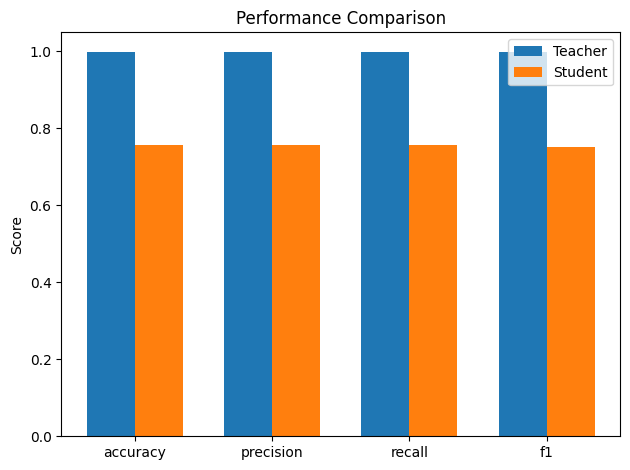

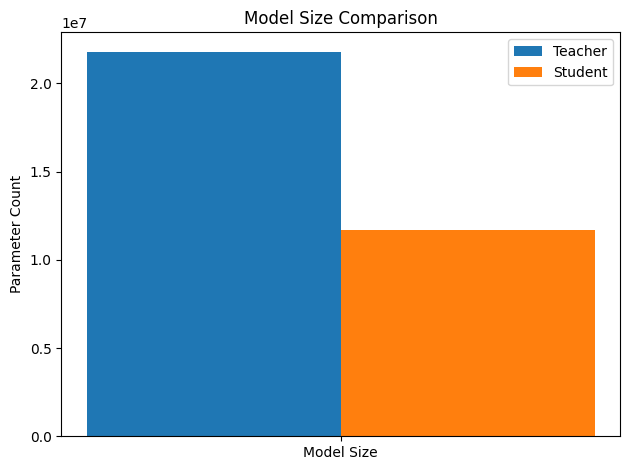

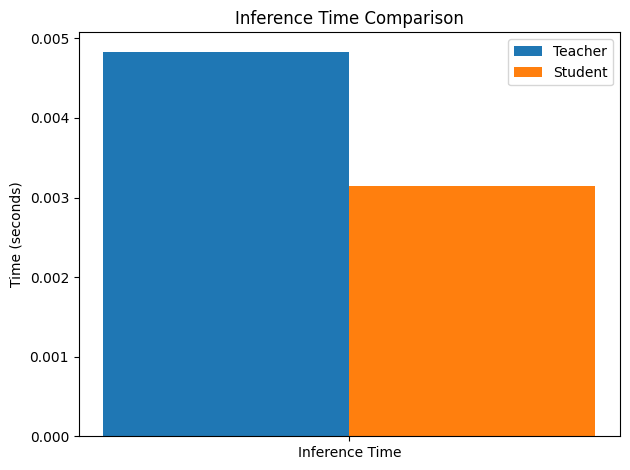

In [13]:
# Comparing the models
teacher_params, student_params = compare_model_size(teacher, student)
teacher_time, student_time = compare_inference_time(teacher, student, trainloader)
performance_metrics = compare_performance_metrics(teacher, student, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (seconds)')

In [13]:
# epochs = list(range(1, num_epochs + 1))  # Create a list of epoch numbers

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, epoch_combined_loss_log, label='Total Loss')
# plt.plot(epochs, epoch_loss_log, label='Cross-Entropy Loss')
# plt.plot(epochs, epoch_fairness_penalty_sp_log, label='SP Fairness Penalty')
# plt.plot(epochs, epoch_fairness_penalty_eo_log, label='EO Fairness Penalty')
# plt.plot(epochs, epoch_fairness_penalty_approx_log, label='Approx Fairness Penalty')
# plt.plot(epochs, epoch_fairness_penalty_approx_eo_log, label='Approx EO Fairness Penalty')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss and Loss Components per Epoch')
# plt.show()

In [14]:
######################### Testing 1 #########################
# Save the student model architecture and weights
torch.save(student.state_dict(), 'student_model_ckd_1.pth')
torch.save(teacher.state_dict(), 'teacher_model_ckd_1.pth')

In [ ]:
######################### Testing 2 #########################
# Save the student model architecture and weights
torch.save(student.state_dict(), 'student_model_ckd_2.pth')
torch.save(teacher.state_dict(), 'teacher_model_ckd_2.pth')

In [16]:

# Define your model architectures as strings
teacher_arch = '''
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        
        self.layer1 = nn.Linear(3072, 1200)
        self.layer2 = nn.Linear(1200, 1200)
        self.layer3 = nn.Linear(1200, 100)
        
        self.dropout_20 = nn.Dropout(0.2)
        self.dropout_50 = nn.Dropout(0.5)

    def forward(self, x):
        # Check input shape and resize if necessary
        if x.shape[-3:] != (3, 32, 32):
            x = x[:, :3, :32, :32]
        
        x = x.contiguous().view(x.size(0), -1)  # Flatten the input
        x = self.dropout_20(x)
        x = F.relu(self.layer1(x))
        x = self.dropout_50(x)
        x = F.relu(self.layer2(x))
        x = self.dropout_50(x)
        return self.layer3(x)
'''

student_arch = '''
class Student(nn.Module):
    def __init__(self, use_dropout=False):
        super(Student, self).__init__()
        self.use_dropout = use_dropout
        
        self.layer1 = nn.Linear(3072, 800)
        self.layer2 = nn.Linear(800, 800)
        self.layer3 = nn.Linear(800, 100)
        
        self.dropout_20 = nn.Dropout(0.2)
        self.dropout_50 = nn.Dropout(0.5)

    def forward(self, x):
        # Check input shape and resize if necessary
        if x.shape[-3:] != (3, 32, 32):
            x = x[:, :3, :32, :32]
            
        x = x.contiguous().view(x.size(0), -1)  # Flatten the input
        if self.use_dropout:
            x = self.dropout_20(x)
        x = F.relu(self.layer1(x))
        if self.use_dropout:
            x = self.dropout_50(x)
        x = F.relu(self.layer2(x))
        if self.use_dropout:
            x = self.dropout_50(x)
        return self.layer3(x)
'''

# Open model_arch.py in write mode
with open('model_arch.py', 'w') as file:
    # Write the model architectures to model_arch.py
    file.write(teacher_arch)
    file.write(student_arch)
